In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
from typing import Dict
import time
import warnings
warnings.filterwarnings('ignore')
import copy
import pickle
from tqdm import tqdm
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from stformer import logger
from stformer.tokenizer import GeneVocab
from stformer.tokenizer import tokenize_and_pad_batch
from stformer.model import TransformerModel

In [2]:
class SlideData():
    def __init__(self, data_path, slide, label_path, vocab, pad_value, pad_token):
        self.data_path = data_path
        self.slide = slide
        self.label_path = label_path 
        self.vocab = vocab
        self.pad_value = pad_value
        self.pad_token = pad_token
        self.load_data()
    
    def load_data(self):
        adata = sc.read_h5ad(f'{self.data_path}/{self.slide}_Visium_deconv.h5ad')

        scfoundation_gene_df = pd.read_csv(f'{tokenizer_dir}/scfoundation_gene_df.csv')
        scfoundation_gene_df.set_index('gene_ids', inplace=True)
        total_gene_num = adata.shape[1]
        adata = adata[:, adata.var_names.isin(scfoundation_gene_df.index)]
        adata.var['gene_name'] = scfoundation_gene_df.loc[adata.var_names, 'gene_symbols'].values
        seleted_gene_num = adata.shape[1]
        genes = adata.var["gene_name"].tolist()
        gene_ids = np.array(self.vocab(genes), dtype=int)

        logger.info(
            f"match {seleted_gene_num}/{total_gene_num} genes "
            f"in vocabulary of size 19264."
        )

        df_label = pd.read_csv(f'{self.label_path}', header=0)
        df_label = df_label[df_label['gene_ids'].isin(adata.var_names)]
        gene_targets = adata.var.loc[df_label['gene_ids'],'gene_name'].values
        gene_targets = np.array(self.vocab(gene_targets.tolist()))
        gene_labels = df_label['label'].values
        gene2label = dict(zip(gene_targets, gene_labels))
        for g in gene_ids:
            if g not in gene2label:
                gene2label[g] = -100
        gene2label[self.vocab[self.pad_token]] = -100

        ligand_database = pd.read_csv(tokenizer_dir+'ligand_database.csv', header=0, index_col=0)
        ligand_symbol = ligand_database[ligand_database.sum(1)>1].index.values
        ligand_ids = self.vocab(ligand_symbol.tolist())
        adata = adata[(adata[:,adata.var['gene_name'].isin(ligand_symbol)].X.sum(1)>0).A.T[0],:]
            
        celltype_proportion = adata.obsm['q05_cell_abundance_w_sf']
        celltype_proportion.rename(columns=lambda x: x[23:], inplace=True)
        celltype_proportion = celltype_proportion.div(celltype_proportion.sum(axis=1), axis=0)
        celltype_proportion[celltype_proportion < 0.05] = 0
        celltype_proportion = celltype_proportion.div(celltype_proportion.sum(axis=1), axis=0)

        for celltype in adata.layers.keys():
            adata.X = adata.layers[celltype]
            sc.pp.normalize_total(adata, target_sum=1e4)
            sc.pp.log1p(adata)
            adata.uns.pop('log1p')
            adata.layers[celltype] = adata.X

        self.adata = adata
        self.celltype_proportion = celltype_proportion
        self.gene_ids = gene_ids
        self.ligand_ids = ligand_ids
        self.gene_targets = gene_targets
        self.gene_labels = gene_labels
        self.gene2label = gene2label
    
    def get_niche_samples(self):
        samples_expression = []
        samples_ctprop = []
        celltypes_labels = []
        for i in range(self.adata.shape[0]):
            ct_prop = self.celltype_proportion.iloc[i][self.celltype_proportion.iloc[i]>0]

            niche_counts = np.concatenate([self.adata.layers[ct][i].A for ct in ct_prop.index])
            niche_counts[:,~np.isin(self.gene_ids, self.ligand_ids)] = 0
            niche_ctprop = ct_prop.values

            for ct in ct_prop.index:
                counts = self.adata.layers[ct][i].A
                samples_expression.append(np.concatenate([counts, niche_counts],axis=0))
                samples_ctprop.append(niche_ctprop)
                celltypes_labels.append(ct)

        self.expression = samples_expression
        self.ctprop = samples_ctprop
        self.celltypes = celltypes_labels

    def tokenize_data(self, train_index, valid_index):
        samples_expression = self.expression

        gene_targets_train = self.gene_targets[train_index]
        gene_targets_valid = self.gene_targets[valid_index]
        train_index = [k for k in range(len(samples_expression)) if len(set(self.gene_ids[np.nonzero(samples_expression[k][0])[0]]).intersection(set(gene_targets_train)))>0]
        valid_index = [k for k in range(len(samples_expression)) if len(set(self.gene_ids[np.nonzero(samples_expression[k][0])[0]]).intersection(set(gene_targets_valid)))>0]

        train_data = [samples_expression[k] for k in train_index]
        train_ctprop = [self.ctprop[k] for k in train_index]
        valid_data = [samples_expression[k] for k in valid_index]
        valid_ctprop = [self.ctprop[k] for k in valid_index]
        
        max_seq_len = np.max(np.count_nonzero(self.adata.X.A, axis=1))+2
        max_niche_cell_num = (self.celltype_proportion>0).sum(1).max()
        self.max_seq_len = max_seq_len
        self.max_niche_cell_num = max_niche_cell_num

        tokenized_train = tokenize_and_pad_batch(
            train_data,
            train_ctprop,
            self.gene_ids,
            max_len = max_seq_len,
            max_niche_cell_num = max_niche_cell_num,
            vocab = self.vocab,
            pad_token = self.pad_token,
            pad_value = self.pad_value,
            append_cls = False,  # append <cls> token at the beginning
            include_zero_gene = False,
        )

        tokenized_valid = tokenize_and_pad_batch(
            valid_data,
            valid_ctprop,
            self.gene_ids,
            max_len = max_seq_len,
            max_niche_cell_num = max_niche_cell_num,
            vocab = self.vocab,
            pad_token = self.pad_token,
            pad_value = self.pad_value,
            append_cls = False,
            include_zero_gene = False,
        )
   
        gene2label_train = self.gene2label.copy()
        for gene in gene2label_train:
            if gene not in gene_targets_train:
                gene2label_train[gene] = -100
        gene2label_valid = self.gene2label.copy()
        for gene in gene2label_valid:
            if gene not in gene_targets_valid:
                gene2label_valid[gene] = -100

        tokenized_train['center_labels'] = torch.from_numpy(np.vectorize(gene2label_train.get)(tokenized_train['center_genes'].numpy()))
        tokenized_valid['center_labels'] = torch.from_numpy(np.vectorize(gene2label_valid.get)(tokenized_valid['center_genes'].numpy()))
        
        logger.info(
            f"train set number of samples: {tokenized_train['center_genes'].shape[0]}, "
            f"\n\t feature length of center cell: {tokenized_train['center_genes'].shape[1]}"
            f"\n\t feature length of niche cells: {tokenized_train['niche_genes'].shape[1]}"
        )
        logger.info(
            f"valid set number of samples: {tokenized_valid['center_genes'].shape[0]}, "
            f"\n\t feature length of center cell: {tokenized_valid['center_genes'].shape[1]}"
            f"\n\t feature length of niche cells: {tokenized_valid['niche_genes'].shape[1]}"
        )

        self.tokenized_train = tokenized_train
        self.tokenized_valid = tokenized_valid

    def prepare_data(self):
        self.train_data_pt = {
            "center_gene_ids": self.tokenized_train["center_genes"],
            "input_center_values": self.tokenized_train["center_values"],
            "target_center_values": self.tokenized_train["center_values"],
            "niche_gene_ids": self.tokenized_train["niche_genes"],
            "input_niche_values": self.tokenized_train["niche_values"],
            "niche_feature_lens": self.tokenized_train["niche_feature_lens"],
            "cross_attn_bias": self.tokenized_train["cross_attn_bias"],
            "center_labels": self.tokenized_train["center_labels"],
        }

        self.valid_data_pt = {
            "center_gene_ids": self.tokenized_valid["center_genes"],
            "input_center_values": self.tokenized_valid["center_values"],
            "target_center_values": self.tokenized_valid["center_values"],
            "niche_gene_ids": self.tokenized_valid["niche_genes"],
            "input_niche_values": self.tokenized_valid["niche_values"],
            "niche_feature_lens": self.tokenized_valid["niche_feature_lens"],
            "cross_attn_bias": self.tokenized_valid["cross_attn_bias"],
            "center_labels": self.tokenized_valid["center_labels"],
        }

    def prepare_dataloader(self, batch_size):
        train_loader = DataLoader(
            dataset=SeqDataset(self.train_data_pt),
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=min(len(os.sched_getaffinity(0)), batch_size // 2),
            pin_memory=True,
        )

        valid_loader = DataLoader(
            dataset=SeqDataset(self.valid_data_pt),
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=min(len(os.sched_getaffinity(0)), batch_size // 2),
            pin_memory=True,
        )
        return train_loader, valid_loader

class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["center_gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

In [3]:
criterion_cls = nn.CrossEntropyLoss()

def train(model: nn.Module, loader: DataLoader, valid_loader, max_batch) -> None:
    """
    Train the model for one epoch.
    """
    lr = 1e-4
    amp = True
    schedule_ratio = 0.9
    schedule_interval = 1
    log_interval = 10

    optimizer = torch.optim.Adam(
            model.parameters(), lr=lr, eps=1e-4 if amp else 1e-8
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, schedule_interval, gamma=schedule_ratio
    )
    scaler = torch.cuda.amp.GradScaler(enabled=amp)

    model.train()
    total_gcl = 0.0
    total_error = 0.0

    best_model = None
    best_val_auc = 0
    best_fpr = 0
    best_tpr = 0
 
    start_time = time.time()

    num_batches = len(loader)

    for batch, batch_data in enumerate(loader):
        if batch > max_batch:
            break
        niche_feature_lens = batch_data["niche_feature_lens"].to(device)
        if niche_feature_lens.size(0)<7:
            continue
        center_gene_ids = batch_data["center_gene_ids"].to(device)
        input_center_values = batch_data["input_center_values"].to(device)
        niche_gene_ids = batch_data["niche_gene_ids"].to(device)
        input_niche_values = batch_data["input_niche_values"].to(device)
        cross_attn_bias = batch_data["cross_attn_bias"].to(device)
        center_labels = batch_data["center_labels"].to(device)

        encoder_src_key_padding_mask = niche_gene_ids.eq(vocab[pad_token])
        decoder_src_key_padding_mask = center_gene_ids.eq(vocab[pad_token])

        with torch.cuda.amp.autocast(enabled=amp):
            output_dict = model(
                    niche_gene_ids,
                    input_niche_values,
                    encoder_src_key_padding_mask,
                    center_gene_ids,
                    input_center_values,
                    decoder_src_key_padding_mask,
                    cross_attn_bias,
                    GCL = True,
                )
    
            gcl_output = output_dict["gcl_output"]
            batch_logits = gcl_output[torch.logical_or(center_labels==1, center_labels==0)]
            batch_labels = center_labels[torch.logical_or(center_labels==1, center_labels==0)]
            targets = center_gene_ids[torch.logical_or(center_labels==1, center_labels==0)]
            loss_gcl = 0.0
            for t in set(targets):
                loss_gcl += criterion_cls(batch_logits[targets==t], batch_labels[targets==t])
            loss_gcl = loss_gcl/len(set(targets))

            error_rate_gcl = 1 - (
                    (batch_logits.argmax(1) == batch_labels)
                    .sum()
                    .item()
                ) / batch_labels.size(0)

        model.zero_grad()
        scaler.scale(loss_gcl).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        total_gcl += loss_gcl.item()
        total_error += error_rate_gcl

        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            sec_per_batch = (time.time() - start_time) / log_interval
            cur_gcl = total_gcl / log_interval
            cur_error = total_error / log_interval
            logger.info(
                f"| Split {split} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.8f} | sec/batch {sec_per_batch:5.1f} | "
                f"gcl {cur_gcl:5.5f} | "
                f"err {cur_error:1.5f} | "
            )
            total_gcl = 0
            total_error = 0
            start_time = time.time()
        if batch % (10*log_interval) == 0 and batch > 0:  
            val_auc, fpr, tpr = evaluate(model, valid_loader)
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_fpr = fpr
                best_tpr = tpr
                best_model = copy.deepcopy(model) 
            model.train()
            start_time = time.time()
    
    interp_tpr = np.interp(mean_fpr, best_fpr, best_tpr)
    interp_tpr[0] = 0.0
    return best_model, interp_tpr, best_fpr, best_tpr

def py_softmax(vector):
	e = np.exp(vector)
	return e / e.sum()

def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    amp = True
    
    model.eval()
    total_gcl = 0.0
    total_error = 0.0
    total_num = 0

    logits = []
    labels = []
    
    # batch_num = 0
    with torch.no_grad():
        for batch_data in tqdm(loader):
            # batch_num += 1
            # if batch_num>100:
            #     break
            niche_feature_lens = batch_data["niche_feature_lens"].to(device)
            if niche_feature_lens.size(0)<7:
                continue
            center_gene_ids = batch_data["center_gene_ids"].to(device)
            input_center_values = batch_data["input_center_values"].to(device)
            niche_gene_ids = batch_data["niche_gene_ids"].to(device)
            input_niche_values = batch_data["input_niche_values"].to(device)
            cross_attn_bias = batch_data["cross_attn_bias"].to(device)
            center_labels = batch_data["center_labels"].to(device)

            encoder_src_key_padding_mask = niche_gene_ids.eq(vocab[pad_token])
            decoder_src_key_padding_mask = center_gene_ids.eq(vocab[pad_token])

            with torch.cuda.amp.autocast(enabled=amp):
                output_dict = model(
                        niche_gene_ids,
                        input_niche_values,
                        encoder_src_key_padding_mask,
                        center_gene_ids,
                        input_center_values,
                        decoder_src_key_padding_mask,
                        cross_attn_bias,
                        GCL = True,
                    )
                gcl_output = output_dict["gcl_output"]
                batch_logits = gcl_output[torch.logical_or(center_labels==1, center_labels==0)]
                batch_labels = center_labels[torch.logical_or(center_labels==1, center_labels==0)]
                logits.append(batch_logits.to('cpu'))
                labels.append(batch_labels.to('cpu'))

            accuracy = (batch_logits.argmax(1) == batch_labels).sum().item()
            total_error += batch_labels.size(0) - accuracy
            total_num += batch_labels.size(0)
            total_gcl += criterion_cls(batch_logits, batch_labels).item()*batch_labels.size(0) 

    logits = torch.concat(logits).float()
    labels = torch.concat(labels)

    y_score = [py_softmax(item)[1] for item in logits.numpy()]
    y_true = labels.numpy()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_value = auc(fpr, tpr)

    val_err = total_error / total_num
    val_loss = total_gcl / total_num
    logger.info("-" * 89)
    logger.info(
        f"valid accuracy: {1-val_err:1.4f} | "
        f"valid auc: {auc_value:1.4f} | "
        f"valid loss: {val_loss:1.4f} | "
        f"valid err: {val_err:1.4f}"
    )
    logger.info("-" * 89)
    
    return auc_value, fpr, tpr        

def train_and_evaluate(model, train_loader, valid_loader, max_batch):

    best_model, interp_tpr, best_fpr, best_tpr = train(model, train_loader, valid_loader, max_batch)

    return best_model, interp_tpr, best_fpr, best_tpr

In [4]:
from scfoundation import load

def initialize_model(model_file):
    pretrainmodel, pretrainconfig = load.load_model_frommmf('scfoundation/models/models.ckpt')

    model = TransformerModel(
        embsize,
        nhead,
        d_hid,
        nlayers,
        do_gcl = True,
        nlayers_gcl = 3,
        n_gcl =2,
        dropout = dropout,
        cell_emb_style = cell_emb_style,
        scfoundation_token_emb1 = copy.deepcopy(pretrainmodel.token_emb),
        scfoundation_token_emb2 = copy.deepcopy(pretrainmodel.token_emb),
        scfoundation_pos_emb1 = copy.deepcopy(pretrainmodel.pos_emb),
        scfoundation_pos_emb2 = copy.deepcopy(pretrainmodel.pos_emb),
    )

    pt_model = torch.load(model_file, map_location='cpu')

    model_dict = model.state_dict()
    pretrained_dict = pt_model.state_dict()
    pretrained_dict = {
                k: v
                for k, v in pretrained_dict.items()
                if 'cls_decoder' not in k and 'gcl_decoder' not in k
                # if k in model_dict and v.shape == model_dict[k].shape
    }
    # for k, v in pretrained_dict.items():
    #     logger.info(f"Loading params {k} with shape {v.shape}")
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    pre_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())
    for name, para in model.named_parameters():
        para.requires_grad = False
    for name, para in model.gcl_decoder.named_parameters():
        para.requires_grad = True
    post_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

    logger.info(f"Total Pre freeze Params {(pre_freeze_param_count )}")
    logger.info(f"Total Post freeze Params {(post_freeze_param_count )}")

    return model        

In [5]:
embsize = 768 #256
d_hid = 3072 #1024
nhead = 12 #4
nlayers = 6 #12
dropout = 0.1
cell_emb_style = 'max-pool' #"cls"
GCL = True

pad_token = "<pad>"
pad_value = 103
tokenizer_dir = 'stformer/tokenizer/'
vocab_file = tokenizer_dir + "scfoundation_gene_vocab.json"
vocab = GeneVocab.from_file(vocab_file)
vocab.append_token(pad_token)
vocab.set_default_index(vocab[pad_token])

In [6]:
model_file = 'pretraining/model.ckpt'
dataset = 'human_myocardial_infarction_dataset'
slide = 'ACH005'
data_path = f'data/{dataset}/'
label_path = f'gene_lists/signaling_by_TGFB_family_members_REACTOME.csv'
slideData = SlideData(data_path, slide, label_path, vocab, pad_value, pad_token)
slideData.get_niche_samples()

batch_size = 24
max_batch = 500

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
all_roc_auc = []
all_tpr_wt = []

split = 0
for train_index, valid_index in skf.split(slideData.gene_targets, slideData.gene_labels):
    split += 1
    logger.info(f"Cross-validate on dataset {dataset} slide {slide} - split {split}")
    slideData.tokenize_data(train_index, valid_index)
    slideData.prepare_data()
    train_loader, valid_loader = slideData.prepare_dataloader(batch_size)
    
    model = initialize_model(model_file)
    model = nn.DataParallel(model, device_ids = [0, 3, 1])
    device = torch.device("cuda:0")
    model.to(device)

    best_model, interp_tpr, best_fpr, best_tpr = train_and_evaluate(model, train_loader, valid_loader, max_batch)
    all_tpr.append(interp_tpr)
    all_roc_auc.append(auc(best_fpr, best_tpr))
    all_tpr_wt.append(len(best_tpr))

spFormer - INFO - match 11458/12445 genes in vocabulary of size 19264.
spFormer - INFO - Cross-validate on dataset human_myocardial_infarction slide ACH005 - split 1
spFormer - INFO - train set number of samples: 13117, 
	 feature length of center cell: 4465
	 feature length of niche cells: 1664
spFormer - INFO - valid set number of samples: 13075, 
	 feature length of center cell: 4465
	 feature length of niche cells: 1664
spFormer - INFO - Total Pre freeze Params 90035581
spFormer - INFO - Total Post freeze Params 1185794
spFormer - INFO - | Split 1 |  10/547 batches | lr 0.00010000 | sec/batch   1.2 | gcl 0.39003 | err 0.18159 | 
spFormer - INFO - | Split 1 |  20/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.09734 | err 0.02406 | 
spFormer - INFO - | Split 1 |  30/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.03625 | err 0.00816 | 
spFormer - INFO - | Split 1 |  40/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.01425 | err 0.00187 | 
spFormer - INFO - | Split 

100%|██████████| 545/545 [02:45<00:00,  3.29it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6542 | valid auc: 0.6752 | valid loss: 1.0047 | valid err: 0.3458
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 1 | 110/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00180 | err 0.00012 | 
spFormer - INFO - | Split 1 | 120/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00147 | err 0.00008 | 
spFormer - INFO - | Split 1 | 130/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00145 | err 0.00000 | 
spFormer - INFO - | Split 1 | 140/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00430 | err 0.00074 | 
spFormer - INFO - | Split 1 | 150/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00121 | err 0.00000 | 
spFormer - INFO - | Split 1 | 160/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00109 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 545/545 [02:46<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6669 | valid auc: 0.6802 | valid loss: 1.0253 | valid err: 0.3331
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 1 | 210/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00064 | err 0.00000 | 
spFormer - INFO - | Split 1 | 220/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00073 | err 0.00000 | 
spFormer - INFO - | Split 1 | 230/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00065 | err 0.00000 | 
spFormer - INFO - | Split 1 | 240/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00047 | err 0.00000 | 
spFormer - INFO - | Split 1 | 250/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00064 | err 0.00000 | 
spFormer - INFO - | Split 1 | 260/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00046 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 545/545 [02:45<00:00,  3.29it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6722 | valid auc: 0.6872 | valid loss: 1.0663 | valid err: 0.3278
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 1 | 310/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00037 | err 0.00000 | 
spFormer - INFO - | Split 1 | 320/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00033 | err 0.00000 | 
spFormer - INFO - | Split 1 | 330/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00029 | err 0.00000 | 
spFormer - INFO - | Split 1 | 340/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00034 | err 0.00000 | 
spFormer - INFO - | Split 1 | 350/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00032 | err 0.00000 | 
spFormer - INFO - | Split 1 | 360/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00027 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 545/545 [02:45<00:00,  3.29it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6706 | valid auc: 0.6896 | valid loss: 1.1399 | valid err: 0.3294
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 1 | 410/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00021 | err 0.00000 | 
spFormer - INFO - | Split 1 | 420/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00024 | err 0.00000 | 
spFormer - INFO - | Split 1 | 430/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00019 | err 0.00000 | 
spFormer - INFO - | Split 1 | 440/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00026 | err 0.00000 | 
spFormer - INFO - | Split 1 | 450/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00018 | err 0.00000 | 
spFormer - INFO - | Split 1 | 460/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00022 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 545/545 [02:46<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6713 | valid auc: 0.6871 | valid loss: 1.1688 | valid err: 0.3287
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - Cross-validate on dataset human_myocardial_infarction slide ACH005 - split 2
spFormer - INFO - train set number of samples: 13120, 
	 feature length of center cell: 4465
	 feature length of niche cells: 1664
spFormer - INFO - valid set number of samples: 13037, 
	 feature length of center cell: 4465
	 feature length of niche cells: 1664
spFormer - INFO - Total Pre freeze Params 90035581
spFormer - INFO - Total Post freeze Params 1185794
spFormer - INFO - | Split 2 |  10/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.34974 | err 0.15308 | 
spFormer - INFO - | Split 2 |  20/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.09070 | err 0.02546 | 
s

100%|██████████| 544/544 [02:45<00:00,  3.29it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6339 | valid auc: 0.7810 | valid loss: 0.8209 | valid err: 0.3661
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 2 | 110/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00184 | err 0.00022 | 
spFormer - INFO - | Split 2 | 120/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00145 | err 0.00000 | 
spFormer - INFO - | Split 2 | 130/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00116 | err 0.00000 | 
spFormer - INFO - | Split 2 | 140/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00098 | err 0.00000 | 
spFormer - INFO - | Split 2 | 150/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00082 | err 0.00000 | 
spFormer - INFO - | Split 2 | 160/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00090 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 544/544 [02:45<00:00,  3.29it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6364 | valid auc: 0.7871 | valid loss: 0.8533 | valid err: 0.3636
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 2 | 210/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00047 | err 0.00000 | 
spFormer - INFO - | Split 2 | 220/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00060 | err 0.00000 | 
spFormer - INFO - | Split 2 | 230/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00048 | err 0.00000 | 
spFormer - INFO - | Split 2 | 240/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00041 | err 0.00000 | 
spFormer - INFO - | Split 2 | 250/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00049 | err 0.00000 | 
spFormer - INFO - | Split 2 | 260/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00044 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 544/544 [02:45<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6398 | valid auc: 0.7876 | valid loss: 0.8861 | valid err: 0.3602
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 2 | 310/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00027 | err 0.00000 | 
spFormer - INFO - | Split 2 | 320/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00031 | err 0.00000 | 
spFormer - INFO - | Split 2 | 330/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00029 | err 0.00000 | 
spFormer - INFO - | Split 2 | 340/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00028 | err 0.00000 | 
spFormer - INFO - | Split 2 | 350/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00041 | err 0.00000 | 
spFormer - INFO - | Split 2 | 360/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00025 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 544/544 [02:45<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6264 | valid auc: 0.7866 | valid loss: 0.9747 | valid err: 0.3736
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 2 | 410/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00031 | err 0.00000 | 
spFormer - INFO - | Split 2 | 420/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00020 | err 0.00000 | 
spFormer - INFO - | Split 2 | 430/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00021 | err 0.00000 | 
spFormer - INFO - | Split 2 | 440/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00023 | err 0.00000 | 
spFormer - INFO - | Split 2 | 450/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00016 | err 0.00000 | 
spFormer - INFO - | Split 2 | 460/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00036 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 544/544 [02:45<00:00,  3.29it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6236 | valid auc: 0.7805 | valid loss: 1.0247 | valid err: 0.3764
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - Cross-validate on dataset human_myocardial_infarction slide ACH005 - split 3
spFormer - INFO - train set number of samples: 13120, 
	 feature length of center cell: 4465
	 feature length of niche cells: 1664
spFormer - INFO - valid set number of samples: 13088, 
	 feature length of center cell: 4465
	 feature length of niche cells: 1664
spFormer - INFO - Total Pre freeze Params 90035581
spFormer - INFO - Total Post freeze Params 1185794
spFormer - INFO - | Split 3 |  10/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.41970 | err 0.19155 | 
spFormer - INFO - | Split 3 |  20/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.09345 | err 0.01833 | 
s

100%|██████████| 546/546 [02:46<00:00,  3.29it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6365 | valid auc: 0.7579 | valid loss: 0.9239 | valid err: 0.3635
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 3 | 110/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00192 | err 0.00031 | 
spFormer - INFO - | Split 3 | 120/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00143 | err 0.00000 | 
spFormer - INFO - | Split 3 | 130/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00148 | err 0.00013 | 
spFormer - INFO - | Split 3 | 140/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00407 | err 0.00072 | 
spFormer - INFO - | Split 3 | 150/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00147 | err 0.00000 | 
spFormer - INFO - | Split 3 | 160/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00095 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 546/546 [02:46<00:00,  3.29it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6323 | valid auc: 0.7584 | valid loss: 1.0655 | valid err: 0.3677
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 3 | 210/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00050 | err 0.00000 | 
spFormer - INFO - | Split 3 | 220/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00091 | err 0.00000 | 
spFormer - INFO - | Split 3 | 230/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00052 | err 0.00000 | 
spFormer - INFO - | Split 3 | 240/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00044 | err 0.00000 | 
spFormer - INFO - | Split 3 | 250/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00039 | err 0.00000 | 
spFormer - INFO - | Split 3 | 260/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00037 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 546/546 [02:46<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6583 | valid auc: 0.7571 | valid loss: 1.1483 | valid err: 0.3417
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 3 | 310/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00036 | err 0.00000 | 
spFormer - INFO - | Split 3 | 320/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00033 | err 0.00000 | 
spFormer - INFO - | Split 3 | 330/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00029 | err 0.00000 | 
spFormer - INFO - | Split 3 | 340/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00038 | err 0.00000 | 
spFormer - INFO - | Split 3 | 350/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00031 | err 0.00000 | 
spFormer - INFO - | Split 3 | 360/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00033 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 546/546 [02:45<00:00,  3.29it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6389 | valid auc: 0.7507 | valid loss: 1.1948 | valid err: 0.3611
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 3 | 410/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00027 | err 0.00000 | 
spFormer - INFO - | Split 3 | 420/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00037 | err 0.00017 | 
spFormer - INFO - | Split 3 | 430/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00019 | err 0.00000 | 
spFormer - INFO - | Split 3 | 440/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00020 | err 0.00000 | 
spFormer - INFO - | Split 3 | 450/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00017 | err 0.00000 | 
spFormer - INFO - | Split 3 | 460/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00028 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 546/546 [02:46<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6392 | valid auc: 0.7565 | valid loss: 1.1973 | valid err: 0.3608
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - Cross-validate on dataset human_myocardial_infarction slide ACH005 - split 4
spFormer - INFO - train set number of samples: 13120, 
	 feature length of center cell: 4465
	 feature length of niche cells: 1664
spFormer - INFO - valid set number of samples: 13078, 
	 feature length of center cell: 4465
	 feature length of niche cells: 1664
spFormer - INFO - Total Pre freeze Params 90035581
spFormer - INFO - Total Post freeze Params 1185794
spFormer - INFO - | Split 4 |  10/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.36997 | err 0.16314 | 
spFormer - INFO - | Split 4 |  20/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.09152 | err 0.02319 | 
s

100%|██████████| 545/545 [02:45<00:00,  3.29it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6631 | valid auc: 0.7574 | valid loss: 0.7976 | valid err: 0.3369
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 4 | 110/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00159 | err 0.00000 | 
spFormer - INFO - | Split 4 | 120/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00152 | err 0.00000 | 
spFormer - INFO - | Split 4 | 130/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00125 | err 0.00000 | 
spFormer - INFO - | Split 4 | 140/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00428 | err 0.00069 | 
spFormer - INFO - | Split 4 | 150/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00131 | err 0.00000 | 
spFormer - INFO - | Split 4 | 160/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00106 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 545/545 [02:46<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6638 | valid auc: 0.7691 | valid loss: 0.8622 | valid err: 0.3362
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 4 | 210/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00050 | err 0.00000 | 
spFormer - INFO - | Split 4 | 220/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00065 | err 0.00000 | 
spFormer - INFO - | Split 4 | 230/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00054 | err 0.00000 | 
spFormer - INFO - | Split 4 | 240/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00053 | err 0.00000 | 
spFormer - INFO - | Split 4 | 250/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00051 | err 0.00000 | 
spFormer - INFO - | Split 4 | 260/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00048 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 545/545 [02:46<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6611 | valid auc: 0.7619 | valid loss: 0.9399 | valid err: 0.3389
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 4 | 310/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00044 | err 0.00012 | 
spFormer - INFO - | Split 4 | 320/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00045 | err 0.00000 | 
spFormer - INFO - | Split 4 | 330/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00032 | err 0.00000 | 
spFormer - INFO - | Split 4 | 340/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00035 | err 0.00000 | 
spFormer - INFO - | Split 4 | 350/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00028 | err 0.00000 | 
spFormer - INFO - | Split 4 | 360/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00030 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 545/545 [02:46<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6635 | valid auc: 0.7608 | valid loss: 0.9728 | valid err: 0.3365
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 4 | 410/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00023 | err 0.00000 | 
spFormer - INFO - | Split 4 | 420/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00027 | err 0.00000 | 
spFormer - INFO - | Split 4 | 430/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00022 | err 0.00000 | 
spFormer - INFO - | Split 4 | 440/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00020 | err 0.00000 | 
spFormer - INFO - | Split 4 | 450/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00017 | err 0.00000 | 
spFormer - INFO - | Split 4 | 460/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00030 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 545/545 [02:46<00:00,  3.27it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.6764 | valid auc: 0.7663 | valid loss: 0.9757 | valid err: 0.3236
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - Cross-validate on dataset human_myocardial_infarction slide ACH005 - split 5
spFormer - INFO - train set number of samples: 13120, 
	 feature length of center cell: 4465
	 feature length of niche cells: 1664
spFormer - INFO - valid set number of samples: 12939, 
	 feature length of center cell: 4465
	 feature length of niche cells: 1664
spFormer - INFO - Total Pre freeze Params 90035581
spFormer - INFO - Total Post freeze Params 1185794
spFormer - INFO - | Split 5 |  10/547 batches | lr 0.00010000 | sec/batch   0.9 | gcl 0.40861 | err 0.20162 | 
spFormer - INFO - | Split 5 |  20/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.10287 | err 0.02657 | 
s

100%|██████████| 540/540 [02:44<00:00,  3.29it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.5668 | valid auc: 0.6934 | valid loss: 1.2450 | valid err: 0.4332
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 5 | 110/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00160 | err 0.00000 | 
spFormer - INFO - | Split 5 | 120/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00128 | err 0.00000 | 
spFormer - INFO - | Split 5 | 130/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00140 | err 0.00026 | 
spFormer - INFO - | Split 5 | 140/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00465 | err 0.00066 | 
spFormer - INFO - | Split 5 | 150/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00121 | err 0.00000 | 
spFormer - INFO - | Split 5 | 160/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00114 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 540/540 [02:44<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.5657 | valid auc: 0.7028 | valid loss: 1.2223 | valid err: 0.4343
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 5 | 210/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00057 | err 0.00000 | 
spFormer - INFO - | Split 5 | 220/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00064 | err 0.00000 | 
spFormer - INFO - | Split 5 | 230/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00055 | err 0.00000 | 
spFormer - INFO - | Split 5 | 240/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00048 | err 0.00000 | 
spFormer - INFO - | Split 5 | 250/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00050 | err 0.00000 | 
spFormer - INFO - | Split 5 | 260/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00050 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 540/540 [02:44<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.5637 | valid auc: 0.6927 | valid loss: 1.2968 | valid err: 0.4363
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 5 | 310/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00033 | err 0.00000 | 
spFormer - INFO - | Split 5 | 320/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00031 | err 0.00000 | 
spFormer - INFO - | Split 5 | 330/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00030 | err 0.00000 | 
spFormer - INFO - | Split 5 | 340/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00028 | err 0.00000 | 
spFormer - INFO - | Split 5 | 350/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00041 | err 0.00000 | 
spFormer - INFO - | Split 5 | 360/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00025 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 540/540 [02:44<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.5595 | valid auc: 0.6900 | valid loss: 1.4165 | valid err: 0.4405
spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - | Split 5 | 410/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00044 | err 0.00000 | 
spFormer - INFO - | Split 5 | 420/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00020 | err 0.00000 | 
spFormer - INFO - | Split 5 | 430/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00027 | err 0.00000 | 
spFormer - INFO - | Split 5 | 440/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00022 | err 0.00000 | 
spFormer - INFO - | Split 5 | 450/547 batches | lr 0.00010000 | sec/batch   0.7 | gcl 0.00018 | err 0.00000 | 
spFormer - INFO - | Split 5 | 460/547 batches | lr 0.00010000 | sec/batch   0.6 | gcl 0.00023 | err 0.00000 | 
spFormer - INFO 

100%|██████████| 540/540 [02:44<00:00,  3.28it/s]


spFormer - INFO - -----------------------------------------------------------------------------------------
spFormer - INFO - valid accuracy: 0.5591 | valid auc: 0.6892 | valid loss: 1.4113 | valid err: 0.4409
spFormer - INFO - -----------------------------------------------------------------------------------------


In [7]:
import math 

def get_cross_valid_metrics(all_tpr, all_roc_auc, all_tpr_wt):
    wts = [count/sum(all_tpr_wt) for count in all_tpr_wt]
    print(wts)
    all_weighted_tpr = [a*b for a,b in zip(all_tpr, wts)]
    mean_tpr = np.sum(all_weighted_tpr, axis=0)
    mean_tpr[-1] = 1.0
    all_weighted_roc_auc = [a*b for a,b in zip(all_roc_auc, wts)]
    roc_auc = np.sum(all_weighted_roc_auc)
    roc_auc_sd = math.sqrt(np.average((all_roc_auc-roc_auc)**2, weights=wts))
    return mean_tpr, roc_auc, roc_auc_sd, wts

mean_tpr, roc_auc, roc_auc_sd, wts = get_cross_valid_metrics(all_tpr, all_roc_auc, all_tpr_wt)

print(f"Mean ROC AUC: {roc_auc} +/- {roc_auc_sd}")
cv_results = {'roc_auc':roc_auc, 'roc_auc_sd':roc_auc_sd, 'mean_fpr':mean_fpr, 'mean_tpr':mean_tpr, 'all_roc_auc':all_roc_auc, 'wts':wts}
pickle.dump(cv_results, open(f'roc_results/stformer_gcl_{slide}_TGFB-pathway.pkl', 'wb'))

[0.22974495816633533, 0.2013225178869481, 0.200631491659845, 0.20716434729915056, 0.161136684987721]
Mean ROC AUC: 0.7417489198775342 +/- 0.03876296744241102


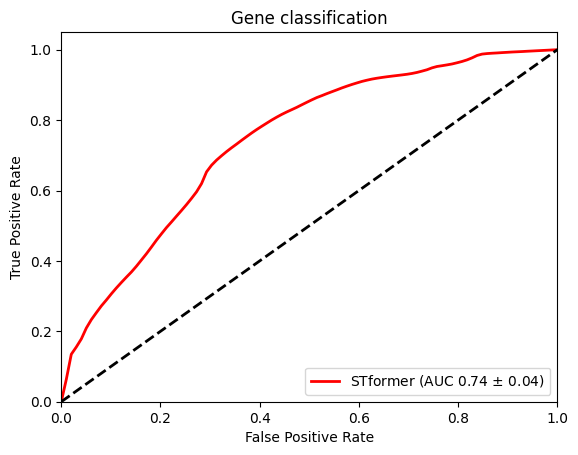

In [8]:
import matplotlib.pyplot as plt

def plot_ROC(bundled_data, title):
    plt.figure()
    lw = 2
    for roc_auc, roc_auc_sd, mean_fpr, mean_tpr, sample, color in bundled_data:
        plt.plot(mean_fpr, mean_tpr, color=color,
                 lw=lw, label="{0} (AUC {1:0.2f} $\pm$ {2:0.2f})".format(sample, roc_auc, roc_auc_sd))
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

bundled_data = [(roc_auc, roc_auc_sd, mean_fpr, mean_tpr, "STformer", "red")]

plot_ROC(bundled_data, 'Gene classification')